# 2-Arm ANCOVA Model for Continuous Outcomes (No Intercept, Fixed Error Variance)

## Model Specification

This notebook implements a 2-arm ANCOVA model **without an intercept** and with **fixed error variance**:

$$\text{outcome} = b_1 \cdot \text{covariate} + b_2 \cdot \text{group} + \epsilon$$

where:
- $b_1$: coefficient for the baseline covariate **(NOT estimated - fixed in simulation)**
- $b_2$: treatment effect (difference between groups) **(parameter to estimate via BayesFlow)**
- $\text{group}$: binary indicator (0 = control, 1 = treatment)
- $\epsilon \sim N(0, 1)$: residual error with **FIXED variance = 1**

**Key features:**
- No intercept term ($\beta_0 = 0$)
- Only 1 parameter estimated: $b_2$ (treatment effect)
- $b_1$ (covariate effect) is simulated but not inferred
- Error variance $\sigma^2 = 1$ (not estimated)

In [1]:
import os

if not os.environ.get("KERAS_BACKEND"):
    os.environ["KERAS_BACKEND"] = "torch"
    
from pathlib import Path
import importlib

import numpy as np
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(2025)

from itertools import product

import keras
import bayesflow as bf

# plotting
import matplotlib.pyplot as plt

# Import ANCOVA-specific functions and configs from the package
from rctbp_bf_training.models.ancova.model import (
    ANCOVAConfig,
    create_ancova_adapter,
    create_simulator,
    create_ancova_workflow_components,
    get_ancova_adapter_spec,
    simulate_cond_batch,
    get_model_metadata,
    save_model_with_metadata,
    load_model_with_metadata,
    create_validation_grid,
    make_simulate_fn,
    make_infer_fn,
)

# Import generic infrastructure
from rctbp_bf_training.core.infrastructure import (
    SummaryNetworkConfig,
    InferenceNetworkConfig,
    WorkflowConfig,
)
from rctbp_bf_training.core.utils import (
    MovingAverageEarlyStopping,
    loguniform_int,  # Used in plotting cells
)
from rctbp_bf_training.core.validation import (
    run_validation_pipeline,
    make_bayesflow_infer_fn,
)

# Create default configuration
config = ANCOVAConfig()
print(f"Config loaded. Model type: ancova_cont_2arms")

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


Config loaded. Model type: ancova_cont_2arms


## Simulator Components

The simulator is built from three functions (defined in `ancova_cont_2arms_fns.py`):
- **prior**: Samples `b_covariate` and `b_group` parameters
- **likelihood**: Simulates ANCOVA data given parameters
- **meta**: Samples context variables (N, p_alloc, prior_df, prior_scale)

In [2]:
# Prior, likelihood, meta functions are all in ancova_cont_2arms_fns
# We use create_simulator() to build the complete simulator with config injection
print("Simulator functions defined in ancova_cont_2arms_fns:")
print("  - prior(prior_df, prior_scale, config, rng)")
print("  - likelihood(b_covariate, b_group, N, p_alloc, rng)")
print("  - meta(config, rng)")

Simulator functions defined in ancova_cont_2arms_fns:
  - prior(prior_df, prior_scale, config, rng)
  - likelihood(b_covariate, b_group, N, p_alloc, rng)
  - meta(config, rng)


In [3]:
# Create simulator using factory function (injects config and RNG)
simulator = create_simulator(config, RNG)

# Test sampling
sim_draws = simulator.sample(100)
print("Simulator output keys:", sim_draws.keys())
print(f"N: {sim_draws['N']}")
print(f"p_alloc: {sim_draws['p_alloc']:.3f}")
print(f"prior_df: {sim_draws['prior_df']}")
print(f"prior_scale: {sim_draws['prior_scale']:.3f}")
print(f"b_covariate shape: {sim_draws['b_covariate'].shape}")
print(f"b_group shape: {sim_draws['b_group'].shape}")
print(f"outcome[0] shape: {sim_draws['outcome'][0].shape}")

Simulator output keys: dict_keys(['N', 'p_alloc', 'prior_df', 'prior_scale', 'b_covariate', 'b_group', 'outcome', 'covariate', 'group'])
N: 979
p_alloc: 0.653
prior_df: 13
prior_scale: 0.593
b_covariate shape: (100, 1)
b_group shape: (100, 1)
outcome[0] shape: (979,)


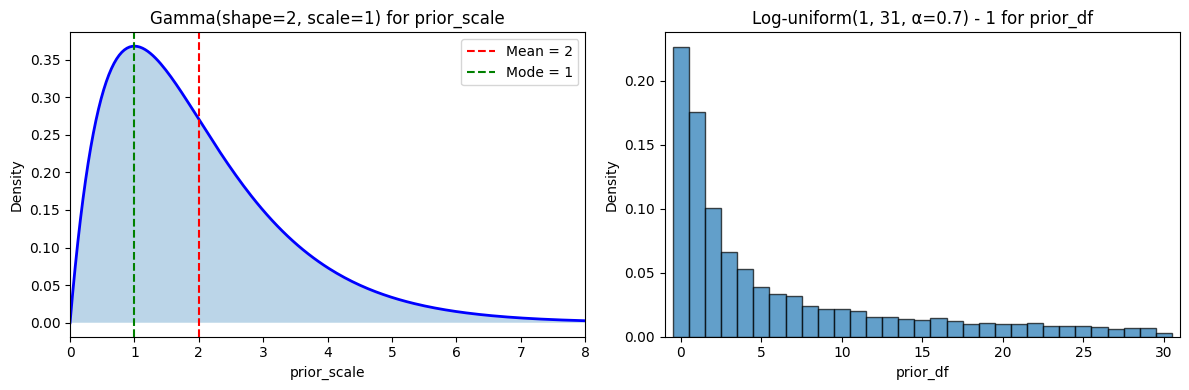

prior_scale: Gamma(shape=2, scale=1) → mean=2, mode=1
prior_df: integer in [0, 30], log-uniform with α=0.7 (skewed toward lower values)


In [4]:
# Visualize the Gamma distribution for prior_scale
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gamma(shape=2, scale=1) for prior_scale
x_gamma = np.linspace(0, 8, 200)
shape, scale = 2, 1
gamma_pdf = stats.gamma.pdf(x_gamma, a=shape, scale=scale)

ax = axes[0]
ax.plot(x_gamma, gamma_pdf, 'b-', lw=2)
ax.fill_between(x_gamma, gamma_pdf, alpha=0.3)
ax.axvline(shape * scale, color='r', ls='--', label=f'Mean = {shape * scale}')
ax.axvline((shape - 1) * scale, color='g', ls='--', label=f'Mode = {(shape - 1) * scale}')
ax.set_xlabel('prior_scale')
ax.set_ylabel('Density')
ax.set_title(f'Gamma(shape={shape}, scale={scale}) for prior_scale')
ax.legend()
ax.set_xlim(0, 8)

# Log-uniform distribution for prior_df (0 to 30)
ax = axes[1]
# Sample from the actual distribution
samples_df = [int(round(loguniform_int(1, 31, alpha=0.7) - 1)) for _ in range(10000)]
ax.hist(samples_df, bins=np.arange(-0.5, 31.5, 1), density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('prior_df')
ax.set_ylabel('Density')
ax.set_title('Log-uniform(1, 31, α=0.7) - 1 for prior_df')
ax.set_xlim(-1, 31)

plt.tight_layout()
plt.show()

print(f"prior_scale: Gamma(shape=2, scale=1) → mean={shape*scale}, mode={(shape-1)*scale}")
print(f"prior_df: integer in [0, 30], log-uniform with α=0.7 (skewed toward lower values)")

## Adapter

Transform simulator output for neural networks.

In [5]:
# Adapter created via factory function
adapter = create_ancova_adapter()
    
# Test the adapter
processed = adapter(sim_draws)
print("Processed data shapes:")
print("  inference_variables:", processed["inference_variables"].shape)
print("  inference_conditions:", processed["inference_conditions"].shape)
print("  summary_variables:", processed["summary_variables"].shape)

Processed data shapes:
  inference_variables: (100, 1)
  inference_conditions: (100, 4)
  summary_variables: (100, 979, 3)


## Networks and Workflow

## Current API Overview

The package uses a decoupled, factory-based API for maximum flexibility:

**Configuration System:**
- `ANCOVAConfig`: Top-level configuration bundling all settings
  - `WorkflowConfig`: Generic workflow configuration (networks + training)
    - `SummaryNetworkConfig`: Independent summary network settings
    - `InferenceNetworkConfig`: Independent inference network settings
    - `TrainingConfig`: Training hyperparameters
  - `PriorConfig`: ANCOVA-specific prior settings
  - `MetaConfig`: ANCOVA-specific meta-parameter ranges

**Factory Functions:**
- `create_simulator()`: Creates BayesFlow simulator from config
- `create_ancova_adapter()`: Creates adapter for ANCOVA data transformation
- `create_ancova_workflow_components()`: Creates all components (summary_net, inference_net, adapter) at once

This design allows:
- Independent tuning of summary and inference networks
- Easy swapping of network architectures
- Reuse across different models
- Clear separation of model-specific and generic code

In [6]:
# =============================================================================
# HYPERPARAMETERS (from config, can be overridden)
# =============================================================================
# Access network configuration through the config object

# Print current configuration
print("Network configuration:")
print(f"  Summary network: dim={config.workflow.summary_network.summary_dim}, "
      f"depth={config.workflow.summary_network.depth}, "
      f"width={config.workflow.summary_network.width}, "
      f"dropout={config.workflow.summary_network.dropout}")
print(f"  Inference network: depth={config.workflow.inference_network.depth}, "
      f"hidden={config.workflow.inference_network.hidden_sizes}, "
      f"dropout={config.workflow.inference_network.dropout}")
print(f"\nTraining configuration:")
print(f"  lr={config.workflow.training.initial_lr}, "
      f"batch={config.workflow.training.batch_size}, "
      f"epochs={config.workflow.training.epochs}")

Network configuration:
  Summary network: dim=10, depth=3, width=64, dropout=0.05
  Inference network: depth=7, hidden=(128, 128), dropout=0.2

Training configuration:
  lr=0.0007, batch=320, epochs=200


In [7]:
# Build networks using the ANCOVA factory function
# This creates all workflow components at once using the current API
summary_network, inference_network, adapter = create_ancova_workflow_components(config)

print(f"Networks created:")
print(f"  Summary: {summary_network}")
print(f"  Inference: {inference_network}")
print(f"  Adapter spec: {get_ancova_adapter_spec().set_keys}")

Networks created:
  Summary: <DeepSet name=deep_set, built=False>
  Inference: <CouplingFlow name=coupling_flow, built=False>
  Adapter spec: ['outcome', 'covariate', 'group']


In [8]:
# Optimizer with decaying learning rate
train_config = config.workflow.training
steps_per_epoch = train_config.batch_size * train_config.batches_per_epoch
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=train_config.initial_lr,
    decay_steps=steps_per_epoch,
    decay_rate=train_config.decay_rate,  
    staircase=True,
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Create workflow using components from factory
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_network,
    summary_network=summary_network,
    optimizer=optimizer,
    inference_conditions=["N", "p_alloc", "prior_df", "prior_scale"],
    checkpoint_name="ancova_cont_2arms"
)

# Compile the approximator (required before training)
workflow.approximator.compile(optimizer=optimizer)

print("Workflow created and compiled")

Workflow created and compiled


## Training

Train the approximator to learn the posterior distribution of `b_covariate`.

In [9]:
# MovingAverageEarlyStopping imported from utils (see imports cell)
print("MovingAverageEarlyStopping available from utils")

MovingAverageEarlyStopping available from utils


In [ ]:
callback = MovingAverageEarlyStopping(
    window=train_config.early_stopping_window, 
    patience=train_config.early_stopping_patience
)

history = workflow.fit_online(
    epochs=100, 
    batch_size=256,     
    num_batches_per_epoch=50, 
    validation_data=500,
    callbacks=[callback]
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 656ms/step - loss: 4.4638 - val_loss: -2.0170 - moving_avg_val_loss: -2.0170
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 655ms/step - loss: -0.9583 - val_loss: -2.8575 - moving_avg_val_loss: -2.4373
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 659ms/step - loss: 1.4311 - val_loss: -2.3209 - moving_avg_val_loss: -2.3985
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 648ms/step - loss: 27.8178 - val_loss: -2.2538 - moving_avg_val_loss: -2.3623
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 676ms/step - loss: 0.9023 - val_loss: -2.4531 - moving_avg_val_loss: -2.3805
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - loss: -0.2566 - val_loss: -2.7815 - moving_avg_val_loss: -2.4473
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 672ms/step - loss: -2.9200 - val_loss: -3.1662 - moving_avg_val_loss: -2.5500
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 594ms/step - loss: -2.3846 - val_loss: -3.2355 - moving_avg_val_loss: -2.6357
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━

In [ ]:
f = bf.diagnostics.plots.loss(history)

## Diagnostics

Validate the trained approximator with simulation-based calibration and recovery diagnostics.

### All-in-One Diagnostic Plots

Generate all standard diagnostic plots at once using the built-in method.

In [ ]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simulator.sample(1000)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

# Compute metrics for the validation set
metrics = workflow.compute_default_diagnostics(test_data=val_sims)
metrics["b_group"]

In [ ]:
print(val_sims.keys())
print(val_sims['N'])
print(val_sims['p_alloc'])
print(val_sims['group'].dtype)

In [ ]:
# Import diagnostic plotting functions from the package
from rctbp_bf_training.plotting import diagnostics as plot

### Combined Diagnostic Dashboard

All calibration diagnostics in one comprehensive view.

In [ ]:
# Create diagnostic dashboard using BayesFlow plots + coverage difference
fig = plot.plot_diagnostic_dashboard(
    estimates=post_draws,
    targets=val_sims,
    param_key="b_group",
    variable_name=r"$b_2$ (treatment effect)"
)
plt.show()

# Validation on Conditions Grid

### Simulation Function
Function to simulate and fit one condition on a grid of parameters.

In [ ]:
# Validation functions are all imported from the package (see imports cell)
# - make_simulate_fn: creates simulation function for validation
# - make_bayesflow_infer_fn: creates inference function wrapper
# - run_validation_pipeline: runs complete validation on condition grid

print("Validation functions available from package:")
print("  - make_simulate_fn from rctbp_bf_training.models.ancova.model")
print("  - make_bayesflow_infer_fn from rctbp_bf_training.core.validation")
print("  - run_validation_pipeline from rctbp_bf_training.core.validation")

### Condition Grid

In [ ]:
# Define parameter ranges for the validation grid
b_covariate_vals = [-0.5, 0.5]
b_group_vals = [0.0, 0.5, 1.0]
N_vals = [20, 1000]
p_alloc_vals = [0.5]
prior_df_vals = [0, 3]  # 0 = Normal, 10 = moderate t, 50 = nearly Normal
prior_scale_vals = [0.1, 1, 10]

# Build conditions grid with proper format for run_validation_pipeline
conditions = []
for idx, (n, p, b_cov, b_grp, pdf, psc) in enumerate(
    product(N_vals, p_alloc_vals, b_covariate_vals, b_group_vals, prior_df_vals, prior_scale_vals)
):
    conditions.append({
        "id_cond": idx,
        "n_total": n,
        "p_alloc": p,
        "b_covariate": b_cov,
        "b_arm_treat": b_grp,  # true treatment effect
        "prior_df": pdf,
        "prior_scale": psc,
    })

print(f"Total conditions: {len(conditions)}")
print(f"Example condition: {conditions[0]}")

### Run Validation

In [ ]:
# Use the trained workflow's approximator (or load from checkpoint)
# model_path = "checkpoints/ancova_cont_2arms.keras"
# model_ancova = keras.saving.load_model(model_path)
model_ancova = workflow.approximator

# Create adapters using imported factory functions
simulate_fn = make_simulate_fn(rng=RNG)
infer_fn = make_bayesflow_infer_fn(
    model_ancova, 
    param_key="b_group",
    data_keys=["outcome", "covariate", "group"],
    context_keys={"N": int, "p_alloc": float, "prior_df": float, "prior_scale": float}
)

# Run the complete validation pipeline
results = run_validation_pipeline(
    conditions_list=conditions,
    n_sims=1000,
    n_post_draws=1000,
    simulate_fn=simulate_fn,
    infer_fn=infer_fn,
    true_param_key="b_arm_treat",
    verbose=True
)

In [ ]:
# Extract results
metrics = results["metrics"]
metrics["condition_metrics"]


In [ ]:
# Extract results
metrics = results["metrics"]

# Condition-level summary statistics
display(metrics["condition_summary"].round(3))

In [ ]:
# Plot comprehensive SBC diagnostics (4 panels: histogram, ECDF, coverage, recovery)
from rctbp_bf_training.plotting import diagnostics as plot
importlib.reload(plot)

# Works directly on the metrics dict - shows all conditions combined
fig = plot.plot_sbc_diagnostics(metrics)

# Print key SBC test statistics
print(f"SBC KS p-value: {metrics['summary']['sbc_ks_pvalue']:.4f}")
print(f"SBC C2ST accuracy: {metrics['summary']['sbc_c2st_accuracy']:.4f} (0.5 = well-calibrated)")

In [ ]:
importlib.reload(plot)
max_conditions=len(metrics['condition_metrics'])
fig = plot.plot_histogram_by_condition(metrics, max_conditions=max_conditions)

## Saving the Trained Model

In [ ]:
# Load model with metadata
model_path = "checkpoints/ancova_cont_2arms"
loaded_model, loaded_metadata = load_model_with_metadata(model_path)

print("Model loaded successfully")
if loaded_metadata:
    print(f"Created: {loaded_metadata.get('created_at', 'unknown')}")
    print(f"Model type: {loaded_metadata.get('model_type', 'unknown')}")